In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch.nn.functional as F
import math
def linear_beta_schedule(timesteps, start=0.0001, end=0.002):
    return torch.linspace(start, end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = torch.linspace(0, timesteps, timesteps+1)
    alphas_cumprod = torch.cos((steps / timesteps + s) / (1 + s) * math.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 500
betas = cosine_beta_schedule(timesteps=T)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [3]:
import torchvision
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 128
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.Flowers102(root=".", download=True, 
                                         transform=data_transform)

    
    return train
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 344862509/344862509 [00:23<00:00, 14501603.59it/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 342921.92it/s]


100%|██████████| 14989/14989 [00:00<00:00, 9323509.22it/s]


/tmp/ipykernel_37/1683667406.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


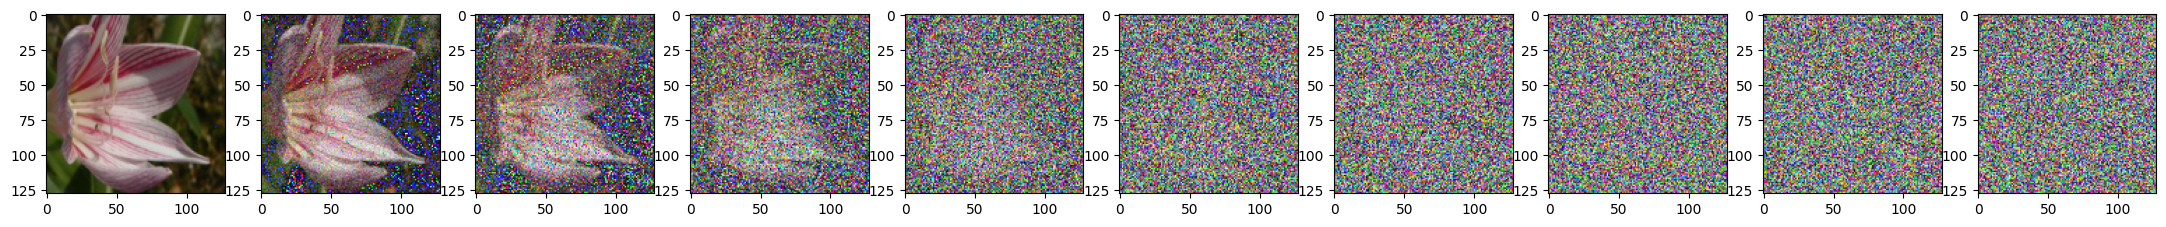

In [4]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(30,30))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [5]:
image.shape

torch.Size([128, 3, 128, 128])

In [6]:
from torch import nn
import math
import torch

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 64, 128, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 128, 64, 64)
        out_dim = 3 
        time_emb_dim = 128

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet with skip connections
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        
        residual_inputs = residual_inputs[::-1]  # Reverse to match with the upsampling layers

        for i, up in enumerate(self.ups):
            residual_x = residual_inputs[i]
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  64360003


In [7]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [8]:
PATH="/kaggle/input/flower-generation/pytorch/default/1/model_v3_128x128.pth"
model = SimpleUnet()
model = torch.load(PATH, weights_only=False)
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  64360003


In [9]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

Epoch 0 Loss: 0.12097449600696564 


/tmp/ipykernel_37/4096756819.py:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


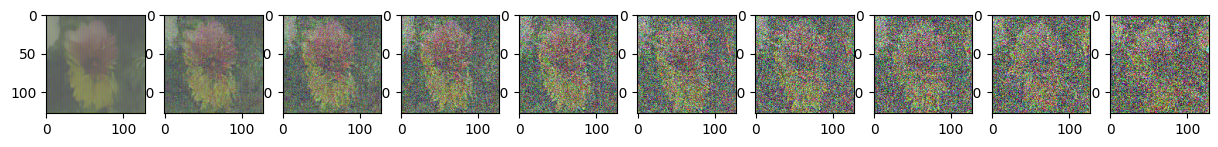

Epoch 10 Loss: 0.10893252491950989 
Epoch 20 Loss: 0.11138051003217697 
Epoch 30 Loss: 0.11566471308469772 
Epoch 40 Loss: 0.11303967237472534 
Epoch 50 Loss: 0.11990956962108612 


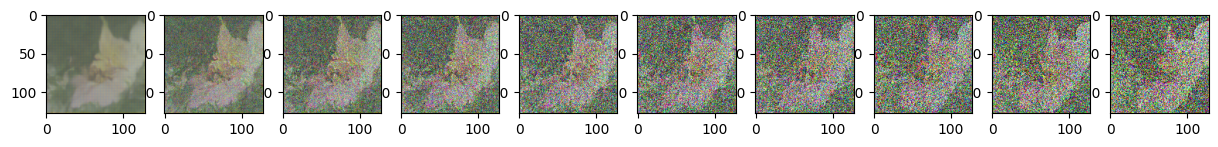

Epoch 60 Loss: 0.1038556694984436 
Epoch 70 Loss: 0.11651202291250229 
Epoch 80 Loss: 0.11921760439872742 
Epoch 90 Loss: 0.1099909171462059 
Epoch 100 Loss: 0.10816684365272522 


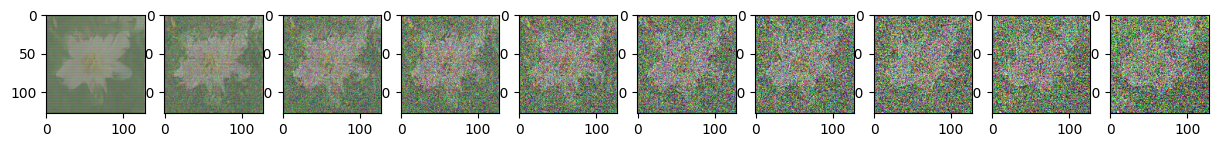

Epoch 110 Loss: 0.12515035271644592 
Epoch 120 Loss: 0.10483699291944504 
Epoch 130 Loss: 0.10295727103948593 
Epoch 140 Loss: 0.11121358722448349 
Epoch 150 Loss: 0.12019955366849899 


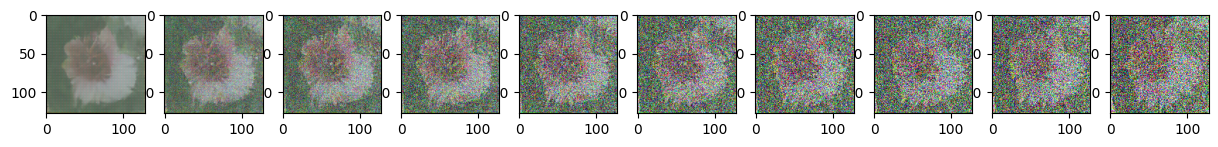

Epoch 160 Loss: 0.11901360750198364 
Epoch 170 Loss: 0.10901596397161484 
Epoch 180 Loss: 0.10105760395526886 
Epoch 190 Loss: 0.09874948114156723 
Epoch 200 Loss: 0.08605320751667023 


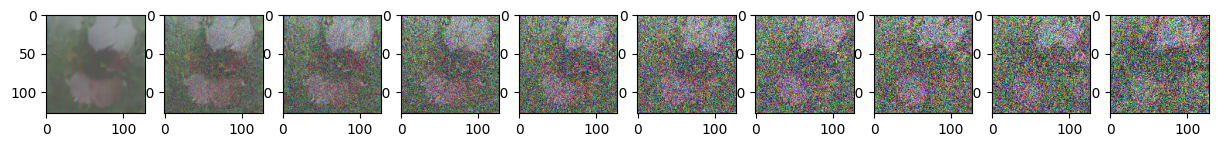

Epoch 210 Loss: 0.10770052671432495 
Epoch 220 Loss: 0.11207932233810425 
Epoch 230 Loss: 0.12229504436254501 
Epoch 240 Loss: 0.1011185273528099 
Epoch 250 Loss: 0.10316269844770432 


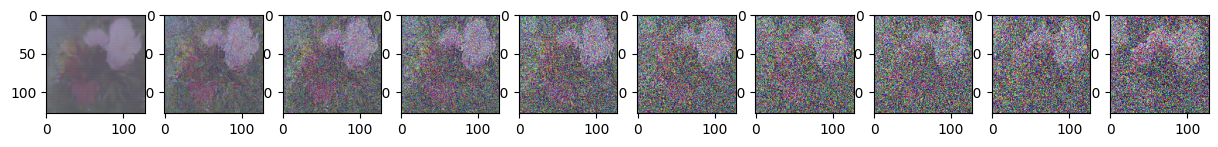

Epoch 260 Loss: 0.11444878578186035 
Epoch 270 Loss: 0.11144515126943588 
Epoch 280 Loss: 0.11248761415481567 
Epoch 290 Loss: 0.10571396350860596 
Epoch 300 Loss: 0.10638850927352905 


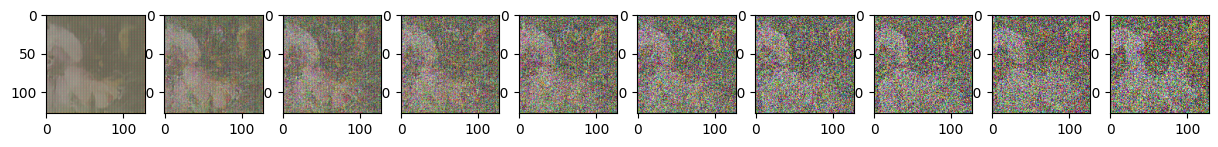

Epoch 310 Loss: 0.10520510375499725 
Epoch 320 Loss: 0.11140452325344086 
Epoch 330 Loss: 0.08997863531112671 
Epoch 340 Loss: 0.10620079934597015 
Epoch 350 Loss: 0.12355731427669525 


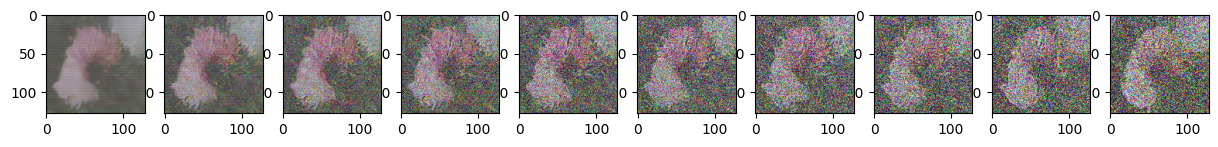

Epoch 360 Loss: 0.11352322995662689 
Epoch 370 Loss: 0.12036913633346558 
Epoch 380 Loss: 0.11564761400222778 
Epoch 390 Loss: 0.11465418338775635 
Epoch 400 Loss: 0.11490073055028915 


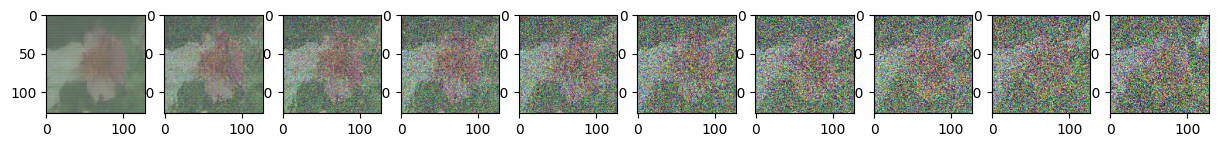

Epoch 410 Loss: 0.10092708468437195 
Epoch 420 Loss: 0.12502652406692505 
Epoch 430 Loss: 0.09868964552879333 
Epoch 440 Loss: 0.11022135615348816 
Epoch 450 Loss: 0.09859919548034668 


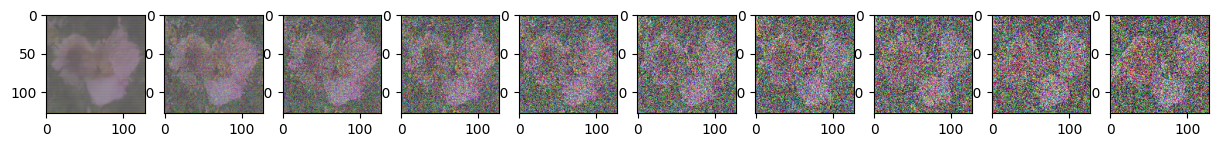

Epoch 460 Loss: 0.10354851186275482 
Epoch 470 Loss: 0.12323503941297531 
Epoch 480 Loss: 0.09671854227781296 
Epoch 490 Loss: 0.11456900835037231 
Epoch 500 Loss: 0.09448830783367157 


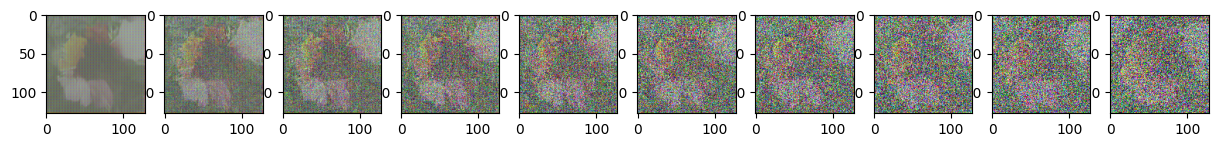

In [13]:
from torch.optim import Adam

device = "cuda"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.0007)
epochs = 500 

for epoch in range(epochs+1):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step() 
        
        if epoch % 10 == 0 and step==0:
            print(f"Epoch {epoch} Loss: {loss.item()} ")
            if epoch % 50 == 0 and step==0:
                sample_plot_image()

In [10]:
torch.save(model, 'model_v4_128x128.pth')

In [12]:
PATH="/kaggle/input/flowers-diffusion-128x128/pytorch/default/1/model_128x128.pth"
model = SimpleUnet()
model = torch.load(PATH, weights_only=False)
print(model)

SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [11]:
def show_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    image=reverse_transforms(image)
    return image
    

@torch.no_grad()
def return_img():
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        
    im=show_image(img.detach().cpu())
    return im


IMG_SIZE=128
device='cuda'

<function matplotlib.pyplot.show(close=None, block=None)>

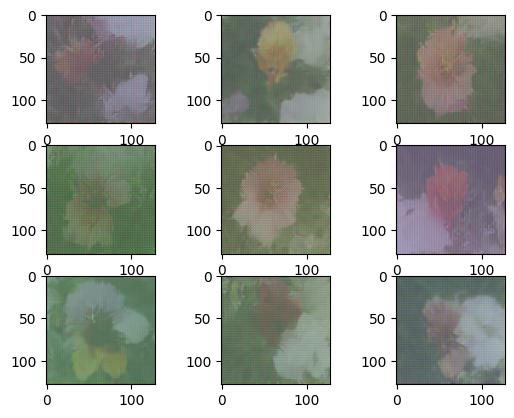

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(return_img())

plt.show